<a href="https://colab.research.google.com/github/No-Qubit-Left-Behind/Control-Engineering-in-TF/blob/master/TF_GRAPE%203%20Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagator - 3 Level System

In [0]:
!pip install ARC-Alkali-Rydberg-Calculator
!pip install qutip

     |████████████████████████████████| 26.5MB 112kB/s 
     |████████████████████████████████| 266kB 46.6MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 235kB 49.9MB/s 
  Created wheel for ARC-Alkali-Rydberg-Calculator: filename=ARC_Alkali_Rydberg_Calculator-2.2.13-cp36-cp36m-linux_x86_64.whl size=27247659 sha256=15bd218cf4abd4ff4395ac498ff60498979cc1cb0f6d311a8cfa2b97b303064e
  Stored in directory: /root/.cache/pip/wheels/8e/c8/9d/9426c28d9e4db94343f2f60f4ca986cf20e62b4cb01a0603a0
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87917 sha256=59dbedfaf1dc2b9fd226c4a5348fe1a49739bff6c8973b37cc6843012d0c4364
  Stored in directory: /root/.cache/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=edaa865f983de7f59c87a4c8e30eb57b23c44fa34e77eb1de610edbf130e5906
  Stored in directory: /root/.cache/pip/wheels/1c

In [99]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import time
from arc import *
from qutip import *
import matplotlib.pyplot as plt


print(tf.__version__)

2.2.0-rc1


In [0]:
######Set all systm parameters: (using ARC)
GHz = 1E9
MHz = 1E6 
kHz = 1E3

ms = 1E-3
us = 1E-6
ns = 1E-9

atom=Rubidium()

##Intermediate excited state: 6P3/2
n_i = 6
l_i = 1
j_i = 1.5
T_i = atom.getStateLifetime(n_i,l_i,j_i)
Gamma_ig = 1/T_i #Decay rate of intermediate state

##Rydberg state: 70 S1/2
n_r = 70
l_r = 0
j_r = 0.5
#Account for blackbody stimulation of Rydberg state to nearby states
#Total lifetime is blackbody + radiative: 1/T_rtotal = 1/T_rBB + 1/T_rRadiative
T_rTot = atom.getStateLifetime(
    n_r,l_r,j_r, temperature= 300, includeLevelsUpTo = n_r + 20
    ) 
#Radiative lifetime: decay to other ground state (so at 0 K temp)
T_rRad = atom.getStateLifetime(n_r,l_r,j_r, temperature= 0) 
#Radiative transition from rydberg to intermediate
T_ri = 1/atom.getTransitionRate(n_r,l_r,j_r, n_i,l_i,j_i, temperature=0) 
T_rgp = 1/(1/T_rRad - 1/T_ri) #radiative transition from rydberg to dark ground states

#Black body stimulated: Transition from rydberg to nearby rydberg
T_rBB = 1/(1/T_rTot - 1/T_rRad)

#Set decay rate to each state
Gamma_ri = 1/T_ri
Gamma_rrp = 1/T_rBB # r to r' (r prime)
Gamma_rgp = 1/T_rgp #rydberg to g' (ground prime dark states)

Gamma_rTot = Gamma_ri + Gamma_rrp + Gamma_rgp #Total decay from Rydberg


###Set system parameters:
Rabi_1 = 2*np.pi * 174 * MHz #Blue Rabi freq.
Rabi_2 = 2*np.pi * 115 * MHz #Red Rabi freq.
Delta_1 = 2*np.pi * 1000 * MHz #Detuning for 3 lvl system at the i state

del_total = 2*np.pi * 0 * MHz #2 photon detuning

##Set time grid:
t_0 = 0 #Initial time
t_f = 200 * ns #Final time
nt = 10 #number of time points
delta_t = (t_f - t_0)/nt #time difference between steps
tlist = np.linspace(0, t_f, nt)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


step  0: infidelity=0.47772
step  1: infidelity=0.25870
step  2: infidelity=0.23173
step  3: infidelity=0.20364
step  4: infidelity=0.14205
step  5: infidelity=0.09607
step  6: infidelity=0.09577
step  7: infidelity=0.09282
step  8: infidelity=0.06694
step  9: infidelity=0.03750
step 10: infidelity=0.02321
step 11: infidelity=0.02513
step 12: infidelity=0.02539
step 13: infidelity=0.01633
step 14: infidelity=0.00749
step 15: infidelity=0.00646
step 16: infidelity=0.00769
step 17: infidelity=0.01144
step 18: infidelity=0.01643
step 19: infidelity=0.01162
step 20: infidelity=0.00828
step 21: infidelity=0.01046
step 22: infidelity=0.01239
step 23: infidelity=0.01159
step 24: infidelity=0.00888
step 25: infidelity=0.00634
step 26: infidelity=0.00513
step 27: infidelity=0.00431
step 28: infidelity=0.00270
step 29: infidelity=0.00097
step 30: infidelity=0.00042
step 31: infidelity=0.00085
step 32: infidelity=0.00126
step 33: infidelity=0.00141
step 34: infidelity=0.00175
step 35: infidelity=

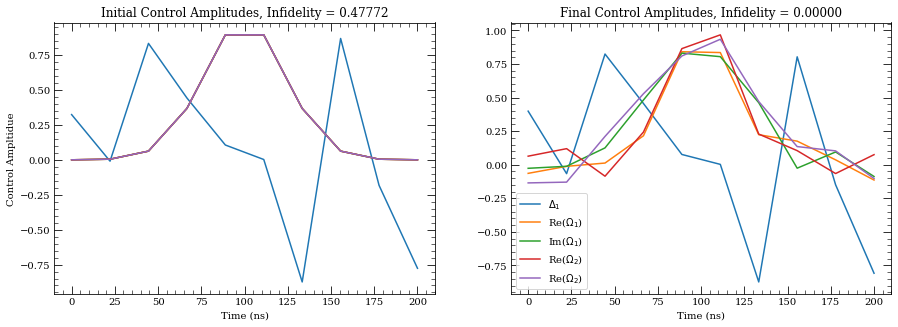

In [123]:
class Propagator:
    def __init__(self, no_of_steps, delta_t, del_total, Delta_1, Rabi_1, Rabi_2, Gamma_r, Gamma_i):
        self.delta_t = delta_t
        self.Rabi_1 = Rabi_1 #Set maximum control amplitude
        self.Rabi_2 = Rabi_2 #Set maximum control amplitude
        self.Delta_1 = Delta_1 #Set maximum control amplitude
        self.del_total = del_total
        self.Gamma_r = Gamma_r
        self.Gamma_i = Gamma_i
        """
            Setting initial and target states
        """        
        self.psi_0 = tf.Variable(tf.zeros([5, 1]))
        self.psi_t = tf.Variable(tf.zeros([5, 1]))
        
        """
            There are 5 control amplitudes: real Rabi_1, imaginary Rabi_1, 
            real Rabi_2, imaginary Rabi_2, Delta_1
        """
        self.ctrl_amplitudes = tf.Variable(
            tf.zeros([no_of_steps, 5], dtype=tf.float64), dtype=tf.float64
        )

        """
            self.contraction_array determines the neccessity for the extra
            matrix multiplication step in the recursive method self.propagate()
            when the intermediate computation array has length not divisible
            by 2
        """
        self.contraction_array = []
        contraction_array_length = int(np.floor(np.log2(no_of_steps)))
        temp_no_of_steps = no_of_steps

        for i in range(contraction_array_length):
            self.contraction_array.append(bool(np.mod(temp_no_of_steps, 2)))
            temp_no_of_steps = np.floor(temp_no_of_steps / 2)
  
        """
            nLevelAtomBasis creates a basis set for an n level atom as qutip
            quantum objects
        """
    def nLevelAtomBasis(self, n):
        states = []
        for n_l in range(0,n):
            states.append(basis(n, n_l))
        return np.array(states, dtype=object)
    
    def Hamiltonian(self):
        """Ladder-system Hamiltonian: Outputs a Qutip quantum object"""
        #Set 5 level sysem operators: includes dark ground and Rydberg states
        g_prime, r_prime, g, i, r = self.nLevelAtomBasis(5)
        
        sig_gpgp = g_prime * g_prime.dag()
        sig_gg = g * g.dag()
        sig_ii = i * i.dag()
        sig_rr = r * r.dag()
        sig_ir = i * r.dag()
        sig_gi = g * i.dag()
        sig_gpi = g_prime * i.dag()
        sig_rpr = r_prime * r.dag()
        sig_gpr = g_prime * r.dag()
        sig_gpgp = g_prime * g.dag()
        
        #Set projectors for finding expectation values:
        proj_g = sig_gg
        proj_i = sig_ii
        proj_r = sig_rr
            
        #Set Hamiltonian parts:    
        H0 = - 1j * self.Gamma_i / 2 * sig_ii - (
            self.del_total + 1j * self.Gamma_r / 2
            ) * sig_rr
        H0_detune = - self.Delta_1 * sig_ii
        
        H1_re = - 1/2 * self.Rabi_1 * (sig_gi + sig_gi.dag())
        H1_im = - 1/2 * 1j * self.Rabi_1 * (sig_gi - sig_gi.dag())
        H2_re = - 1/2 * self.Rabi_2 * (sig_ir + sig_ir.dag())
        H2_im = - 1/2 * 1j * self.Rabi_2 * (sig_ir - sig_ir.dag())

        #Note that H0 does not have a mutliplied control amplitude
        H = [H0, H0_detune, H1_re, H1_im, H2_re, H2_im]

        return H

    """
        exponentials() computes a vector matrix exponential after multiplying
        each self.ctrl_amplitudes row with a the vector of matrices in
        self.generators
    """
    def exponentials(self):
        regularized_amplitudes = 1 / np.sqrt(2) * tf.math.tanh(
            self.ctrl_amplitudes
        )
        #Take Qutip quantum object and cast to tensor objects
        Hamiltonian = []
        for H_part in self.Hamiltonian():
            Hamiltonian.append(tf.cast(H_part, dtype=np.complex128))
        Hamiltonian = tf.stack(Hamiltonian)
        #First element in the Hamiltonian list is not multiplied by a
        #control amplitude
        exponents = (
            Hamiltonian[0] + tf.linalg.tensordot(
                tf.cast(regularized_amplitudes, dtype=tf.complex128), 
                - 1j * Hamiltonian[1:], 1
                )
        ) * self.delta_t
        return tf.linalg.expm(exponents)
    
    """
        propagate  computes the final propagator by recursively multiplying
        each odd element in the list of matrices with each even element --
        if the length of the array is not divisible by 2 an extra computation
        step is added
    """
    def propagate(self):
        step_exps = self.exponentials()
        for is_odd in self.contraction_array:
            if is_odd:
                odd_exp = step_exps[-1, :, :]
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0:-1:2, :, :]
                )
                step_exps = tf.concat([
                    step_exps[0:-1, :, :],
                    [tf.linalg.matmul(odd_exp, step_exps[-1, :, :])]
                ], 0)
            else:
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0::2, :, :]
                )
        return tf.squeeze(step_exps)

    """
        __call__ computes the final propagator fidelity squared with the
        identity operator
    """
    @tf.function
    def infidelity(self):
        propagator = self.propagate()
        psi_0 = tf.cast(self.psi_0, dtype=tf.complex128)
        psi_t = tf.cast(self.psi_t, dtype=tf.complex128)

        final_state = tf.linalg.matvec(propagator, tf.transpose(psi_0))
        overlap = tf.tensordot(tf.math.conj(final_state), psi_t,  axes=1)
        return 1 - tf.math.real((tf.math.conj(overlap) * overlap))


#Set propagator
propagator = Propagator(nt, delta_t, del_total, Delta_1, Rabi_1, Rabi_2, Gamma_rTot, Gamma_ig)

#Set initial and target states:
g_prime, r_prime, g, i, r = propagator.nLevelAtomBasis(5)
psi_0 = g
psi_t = r

propagator.psi_0.assign(psi_0)
propagator.psi_t.assign(psi_t)

#Set initial control amplitude guesses
ctrl_amplitudes_initial = np.random.uniform(-1, 1, [nt, 5])
sigma = t_f/6
tau = t_f
ctrl_amplitudes_initial[:,1:5] = np.tile(
    np.exp(-(tlist - tau/2)**2/sigma**2),
    (4,1)
).T

propagator.ctrl_amplitudes.assign(ctrl_amplitudes_initial)

#Find infidelity using propagator
initial_infidelity = propagator.infidelity()

#Plot initial guess pulses:
labels = ['$\Delta_1$', 'Re($\Omega_1$)', 'Im($\Omega_1$)', 'Re($\Omega_2$)', 'Re($\Omega_2$)']
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ind = 0
for amplitdue in tf.transpose(ctrl_amplitudes_initial):
    ax1.plot(tlist/ns, amplitdue, label = labels[ind])
    ind += 1
ax1.set_title('Initial Control Amplitudes, Infidelity = %2.5f' %(initial_infidelity))
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Control Ampltidue')
plt.legend()

#Optimize pulse with GRAPE:
optimizer = tf.keras.optimizers.Adam(0.01)

def optimization_step():
    with tf.GradientTape() as tape:
        infidelity = propagator.infidelity()
    gradients = tape.gradient(infidelity, [propagator.ctrl_amplitudes])
    optimizer.apply_gradients(zip(gradients, [propagator.ctrl_amplitudes]))
    return infidelity

steps = range(100)
for step in steps:
    current_infidelity = optimization_step()
    print('step %2d: infidelity=%2.5f' %
          (step, current_infidelity))
    
ctrl_amplitudes_final = propagator.ctrl_amplitudes.numpy()

#Plot final results of control amplitudes
labels = ['$\Delta_1$', 'Re($\Omega_1$)', 'Im($\Omega_1$)', 'Re($\Omega_2$)', 'Re($\Omega_2$)']

ind = 0
for amplitdue in tf.transpose(ctrl_amplitudes_final):
    ax2.plot(tlist/ns, amplitdue, label = labels[ind])
    ind += 1
ax2.set_title('Final Control Amplitudes, Infidelity = %2.5f' %(current_infidelity))
ax2.set_xlabel('Time (ns)')
plt.legend()